# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
from pathlib import Path
from typing import Callable as func

import cv2      

from glob import glob

import matplotlib.pyplot as plt                        
%matplotlib inline    

import numpy as np

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.utils.data as data
import torchvision
from torchvision import models as models
from torchvision import transforms as T

from tqdm import tqdm


available_hardware = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(available_hardware)

use_cuda = torch.cuda.is_available()

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


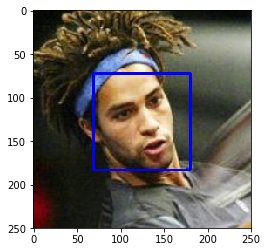

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1800])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def calculate_human_detection_percentage(images: list, images_name: str) -> str:
    detection_results = list(map(face_detector, images))
    success_count = sum(map(int, detection_results))
    success_percentage = success_count / len(detection_results) * 100
    result_message = f"Human face was detected in {success_percentage}% of {images_name}."
    return result_message
    
    
print(calculate_human_detection_percentage(human_files_short, "human pictures"))
print(calculate_human_detection_percentage(dog_files_short, "dog pictures"))

Human face was detected in 99.0% of human pictures.
Human face was detected in 14.000000000000002% of dog pictures.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

In [7]:
class ImageDataSet(data.Dataset):
    def __init__(self, human_paths: list, dog_paths: list) -> None:
        self.paths = self.__make_path_list(human_paths, dog_paths)
        self.transform = self.__make_transform()
        
    @staticmethod
    def __make_label(human: bool) -> torch.Tensor:
        return torch.Tensor((int(human), int(not human)))
        
    @staticmethod
    def __make_path_list(human_paths: list, dog_paths: list) -> list:
        paths = []
        for human_path in human_paths:
            paths.append((human_path, ImageDataSet.__make_label(human=True)))
        for dog_path in dog_paths:
            paths.append((dog_path, ImageDataSet.__make_label(human=False)))
        return paths
        
    @staticmethod
    def __make_transform():
        channel_means = [0.485, 0.456, 0.406]
        channel_stds = [0.229, 0.224, 0.225]
        return T.Compose([T.Resize((224,224)), 
                          T.ToTensor(), 
                          T.Normalize(mean=channel_means, std=channel_stds)])
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index) -> torch.Tensor:
        image_path, label = self.paths[index]
        pil_image = Image.open(image_path)
        torch_image = self.transform(pil_image)
        return torch_image, label

In [8]:
human_validation_index = int(len(human_files[100:]) * 0.8)
dog_validation_index = int(len(dog_files[100:]) * 0.8)

human_train_paths = human_files[100:human_validation_index]
human_validation_paths = human_files[human_validation_index:]
dog_train_paths = dog_files[100:dog_validation_index]
dog_validation_paths = dog_files[dog_validation_index:]

batch_size = 64

train_data = ImageDataSet(human_train_paths, dog_train_paths)
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_data = ImageDataSet(human_validation_paths, dog_validation_paths)
validation_loader = data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=True)

In [9]:
class FaceDetectorMlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2048, 1024)
        self.output = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, input):
        hidden_out = self.dropout(F.relu(self.hidden(input)))
        output_out = torch.sigmoid(self.output(hidden_out))
        return output_out

In [14]:
def load_resnet() -> nn.Module:
    resnet = torchvision.models.resnet50(pretrained=True)
    resnet.to(device)
    for module in resnet.modules():
        for param in module.parameters():
            param.requires_grad = False
    return resnet


def build_face_detector() -> nn.Module:
    frozen_resnet = load_resnet()
    face_detector = FaceDetectorMlp().to(device)
    frozen_resnet.fc = face_detector
    return frozen_resnet


def test_network_architecture(network: nn.Module) -> None:
    modules = dict(network.named_children())
    for name in modules:
        if name != "fc":
            module = modules[name]
            for param in module.parameters():
                assert not param.requires_grad
    for param in modules["fc"].parameters():
        assert param.requires_grad
            

network = build_face_detector()
test_network_architecture(network)

In [16]:
optimizer = torch.optim.Adam(network.fc.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
epoch_count = 1

In [17]:
def training_step(images: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    optimizer.zero_grad()
    output = network.forward(images.to(device))
    loss = criterion(output, labels.to(device))
    loss.backward()
    optimizer.step()
    return loss


def train() -> None:
    network.train()
    train_loss = 0
    for images, labels in train_loader:
        train_loss += training_step(images, labels)
    train_loss /= len(train_loader)
    print(f"Averge training loss: {train_loss}")


def validation_step(images: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    output = network.forward(images.to(device))
    loss = criterion(output, labels.to(device))
    return loss


def validate() -> None:
    network.eval()
    with torch.no_grad():
        validation_loss = 0
        for images, labels in validation_loader:
            validation_loss += validation_step(images, labels)
        validation_loss /= len(validation_loader)
        print(f"Average validation loss: {validation_loss}")
        
        
for epoch in range(epoch_count):
    print(f"Epoch {epoch}")
    train()
    validate()


Epoch 0
Averge training loss: 0.019758984446525574
Average validation loss: 0.0009848435875028372


In [20]:
def make_imagenet_transform():
    expected_image_size = (224, 224)
    channel_means = [0.485, 0.456, 0.406]
    channel_stds = [0.229, 0.224, 0.225]
    transform = T.Compose([T.Resize(expected_image_size), 
                           T.ToTensor(), 
                           T.Normalize(mean=channel_means, std=channel_stds)])
    return transform


def load_image_as_minibatch(path: str) -> torch.Tensor:
    pil_image = Image.open(path)
    transform = make_imagenet_transform()
    torch_image = transform(pil_image)
    image_batch = torch_image.unsqueeze(0)
    return image_batch


def is_face_detected(image_path: str) -> bool:
    torch_image = load_image_as_minibatch(image_path)
    output = network(torch_image.to(device))
    flat_output = output.view(-1)
    face_probability =  flat_output[0].item()
    dog_probability = flat_output[1].item()
    return face_probability > dog_probability


def print_detection_percentage(images: list, detector: func, object_name: str, images_name: str) -> None:
    detection_results = list(map(detector, images))
    success_count = sum(map(int, detection_results))
    success_percentage = success_count / len(detection_results) * 100
    result_message = f"{object_name} was detected in {success_percentage}% of {images_name}."
    print(result_message)

In [21]:
network.eval()
print_detection_percentage(human_files_short, is_face_detected, "Human face", "human pictures")
print_detection_percentage(dog_files_short, is_face_detected, "Human face", "dog pictures")

Human face was detected in 100.0% of human pictures.
Human face was detected in 0.0% of dog pictures.


In [22]:
torch.save(network.state_dict(), "resnet_face_detector.pt")

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [23]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99428225.29it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [24]:
def get_prediction(image_path: str, network: nn.Module) -> int:
    image_batch = load_image_as_minibatch(image_path)
    network.eval()
    output = network.forward(image_batch.to(device))
    probabilities = F.softmax(output, dim=1)
    top_prob, top_index = torch.topk(probabilities, k=1)
    return top_index.item()


def VGG16_predict(img_path: str) -> int:
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    return get_prediction(img_path, VGG16)


VGG16_predict(dog_files_short[50])

181

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [25]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction_index = VGG16_predict(img_path)
    first_dog_index = 151
    last_dog_index = 268
    is_index_dog = prediction_index in range(first_dog_index, last_dog_index+1)
    return is_index_dog


dog_detector(dog_files_short[16])

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [26]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print("Using VGG-16")
print_detection_percentage(human_files_short, dog_detector, "A dog", "human_files_short")
print_detection_percentage(dog_files_short, dog_detector, "A dog", "dog_files_short")

Using VGG-16
A dog was detected in 0.0% of human_files_short.
A dog was detected in 100.0% of dog_files_short.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [27]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)


def dog_detector_resnet(img_path):
    prediction_index = get_prediction(img_path, resnet50)
    first_dog_index = 151
    last_dog_index = 268
    is_index_dog = prediction_index in range(first_dog_index, last_dog_index+1)
    return is_index_dog


print("Using ResNet50")
print_detection_percentage(human_files_short, dog_detector_resnet, "A dog", "human_files_short")
print_detection_percentage(dog_files_short, dog_detector_resnet, "A dog", "dog_files_short")

Using ResNet50
A dog was detected in 0.0% of human_files_short.
A dog was detected in 100.0% of dog_files_short.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [28]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
def make_loader(image_dir: str, transform) -> data.DataLoader:
    batch_size = 24
    data_set = torchvision.datasets.ImageFolder(image_dir, transform=transform)
    loader = data.DataLoader(data_set, batch_size, shuffle=True, pin_memory=True)
    return loader

In [29]:
def find_channel_means_and_stds(image_dir: str) -> torch.Tensor:
    resize_transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
    loader = make_loader(image_dir, resize_transform)
    means = torch.zeros(3).to(device)
    stds = torch.zeros(3).to(device)
    for images, _labels in loader:
        flat_images = images.to(device).flatten(2)
        means += torch.mean(flat_images, dim=[0,2])
        stds += torch.std(flat_images, dim=[0,2])
    means /= len(loader)
    stds /= len(loader)
    return torch.stack((means, stds))
    
    
def find_channel_mean_and_std_for_all_images() -> (torch.Tensor, torch.Tensor): 
    train_stats = find_channel_means_and_stds("dogImages/train")
    valid_stats = find_channel_means_and_stds("dogImages/valid")
    test_stats = find_channel_means_and_stds("dogImages/test")
    total_stats = torch.mean(torch.stack((train_stats, valid_stats, test_stats)), dim=0)
    return total_stats[0], total_stats[1]
   

# dog_means, dog_stds = find_channel_mean_and_std_for_all_images()
# Hardcoding the values below to avoid repeating the calculations
dog_means = [0.4887, 0.4678, 0.3988]
dog_stds = [0.2586, 0.2530, 0.2584]
print(dog_means)
print(dog_stds)

[0.4887, 0.4678, 0.3988]
[0.2586, 0.253, 0.2584]


In [30]:
image_size = 224


def make_train_transform():
    return T.Compose([T.RandomRotation(15),
                      T.RandomHorizontalFlip(),
                      T.Resize(232),
                      T.RandomCrop(image_size),
                      T.ToTensor(),
                      T.Normalize(mean=dog_means, std=dog_stds)])


def make_eval_transform():
    return T.Compose([T.Resize(232),
                      T.CenterCrop(image_size),
                      T.ToTensor(),
                      T.Normalize(mean=dog_means, std=dog_stds)])
    
    
def make_loader_dict() -> dict:
    loader_dict = {}
    loader_dict["train"] = make_loader("dogImages/train", make_train_transform())
    loader_dict["valid"] = make_loader("dogImages/valid", make_eval_transform())
    loader_dict["test"] = make_loader("dogImages/test", make_eval_transform())
    return loader_dict

In [31]:
loader_dict = make_loader_dict()

images, labels = next(iter(loader_dict["train"]))
images.shape

torch.Size([24, 3, 224, 224])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- For the training set, images are resized so that the smaller edge is 232 px and then randomly cropped to a 224x224 px square. This should eliminate some of the background pixels near the edges, increasing density of relevant features in the image. The randomized crop position should help develop better translation invariance. It might also improve detection of partially obscured objects (dogs in this case), due to some parts of the object being cropped-out sometimes. Validation and test images are resized to 232 px and center-cropped to 224x224 px without randomization. The 224 px size was chosen based on fact it was also used for the pre-trained PyTorch models.
- Images from all 3 sets are normalized using average color channel means and standard deviations, calculated accross all available dog images. Additionally, training images have random rotation, horizontal flip and random crop applied, to help the model develop better invariances.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [32]:
class_dirs = [dir for dir in os.scandir("dogImages/test") if dir.is_dir()]
class_count = len(class_dirs)
class_count

133

In [33]:
# define the CNN architecture
class ConvModule(nn.Module):
    def __init__(self, input_depth: int, conv_depths: list, pool_kernel: int, pool_stride: int) -> None:
        super().__init__()
        assert len(conv_depths) > 0, "At least 1 conv_depth must be provided."
        self.conv_layers = nn.ModuleList()
        depths = [input_depth]
        depths.extend(conv_depths)
        for i in range(1,len(depths)):
            conv = nn.Conv2d(depths[i-1], depths[i], kernel_size=3, padding=1)
            self.conv_layers.append(conv)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        
    def forward(self, input):
        conv_out = input
        for conv in self.conv_layers:
            conv_out = F.relu(conv(conv_out))
        output = self.pool(conv_out)
        return output

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super().__init__()
        ## Define layers of a CNN
        self.conv1 = ConvModule(input_depth=3, conv_depths=[64,64,64], pool_kernel=2, pool_stride=2)
        self.conv2 = ConvModule(input_depth=64, conv_depths=[128,128,128], pool_kernel=2, pool_stride=2)
        self.conv3 = ConvModule(input_depth=128, conv_depths=[256,256,256], pool_kernel=2, pool_stride=2)
        self.conv4 = ConvModule(input_depth=256, conv_depths=[512,512,512], pool_kernel=2, pool_stride=2)
        self.fc = nn.Linear(14*14*512+8*8*128, class_count)
        self.sampler = nn.AvgPool2d(kernel_size=7, stride=7)
        self.dropout = nn.Dropout2d(p=0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        sample = self.dropout(self.sampler(x))
        x = self.conv3(x)
        x = self.conv4(x)
        
        sample = sample.view(sample.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = torch.cat([x, sample], dim=1)
        x = F.log_softmax(self.fc(x), dim=1)
        return x

In [34]:
#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
1. First idea was to use one of the most successful architectures, such VGG-16 or ResNet50. However, training such deep networks would require too much computational resources to be feasible for this project.
2. A simple CNN architecture, inspired by the previous Udacity projects was designed. It consisted of a stack of Conv2d and MaxPool2d layers, ending with 2 fully-connected layers. It was small enough to be trained on local hardware. The layers were grouped into modules implemented by the ConvModule class. Each of these modules consisted of 1 or more conv2d layers, which detect image features of increasing complexity and one final max pooling layer, which reduces the x-y dimensions of feature maps. This reduction is important for decreasing memory requirements and for eliminating redundant information from the feature maps.
3. Several short training runs were performed to experiment with the architecture. Adjustments to conv layer depth and count were made, eventually reaching ~8% accuracy after 10 epochs of training.
4. A new idea was implemented: taking the output of one of the middle conv layers, pooling it, and plugging it directly into the final FC layer, after being combined with output of the final conv layer. This modification led to a marked improvement, enabling the network to reach ~15% accuracy. 
5. To reduce the observed divergence of training and validation loss, dropout was added for the middle conv output. After some tuning, this eventually further improved the accuracy to around 17% (after 10 epochs).
6. Since the process mentioned above took several days, it was decided at that point to stop further experimentation and to settle with the current architecture. For the final training session, the model was extended with additional layers and then trained for 100 epochs overnight in the Udacity GPU environment. It managed to reach 29% test accuracy.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [35]:
### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [36]:
torch.cuda.empty_cache()
save_file = 'model_scratch.pt'

In [37]:
def save_model(model: nn.Module, file_path: str) -> None:
    model_state = model.state_dict()
    torch.save(model_state, file_path)
    print(f"Model state saved to {file_path}")


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        print(f"Epoch {epoch}")
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model.forward(data)
            batch_loss = criterion(output, target)
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss
            
        train_loss /= len(loaders["train"])
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                output = model.forward(data)
                batch_loss = criterion(output, target)
                valid_loss += batch_loss
                
        valid_loss /= len(loaders["valid"])

            
        # print training/validation statistics 
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            save_model(model, save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [105]:
if Path(save_file).exists():
    model_scratch.load_state_dict(torch.load(save_file))
    print(f"Existing model loaded for training from {save_file}.")

# train the model
model_scratch = train(3, loader_dict, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, save_file)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(save_file))

Existing model loaded for training from model_scratch.pt.
Epoch 1
Training Loss: 2.018048 	Validation Loss: 3.292536
Model state saved to model_scratch.pt
Epoch 2
Training Loss: 1.980147 	Validation Loss: 3.251581
Model state saved to model_scratch.pt
Epoch 3
Training Loss: 1.968709 	Validation Loss: 3.209728
Model state saved to model_scratch.pt


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [39]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [41]:
torch.cuda.empty_cache()
model_scratch.load_state_dict(torch.load(save_file))

# call test function    
test(loader_dict, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.129917


Test Accuracy: 29% (250/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [42]:
## TODO: Specify data loaders
loader_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa42854bf28>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fa42933e198>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa42933e5c0>}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [50]:
## TODO: Specify model architecture 
class BreedClassifierMlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2048, 1024)
        self.output = nn.Linear(1024, class_count)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, input):
        hidden_out = self.dropout(F.relu(self.hidden(input)))
        output_out = F.log_softmax(self.output(hidden_out), dim=1)
        return output_out


def load_resnet() -> nn.Module:
    resnet = models.resnet50(pretrained=True)
    resnet.to(device)
    for module in resnet.modules():
        for param in module.parameters():
            param.requires_grad = False
    return resnet


def build_breed_network() -> nn.Module:
    frozen_resnet = load_resnet()
    breed_classifier = BreedClassifierMlp().to(device)
    frozen_resnet.fc = breed_classifier
    return frozen_resnet


def test_network_architecture(network: nn.Module) -> None:
    modules = dict(network.named_children())
    for name in modules:
        if name != "fc":
            module = modules[name]
            for param in module.parameters():
                assert not param.requires_grad
    for param in modules["fc"].parameters():
        assert param.requires_grad
            

model_transfer = build_breed_network()
test_network_architecture(model_transfer)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I used similar architecutre as the one implemented for the optional human face detector earlier in the project. ResNet50 was chosen as the base CNN due to its very good performance in the ImageNet challenge. 

After loading, the pre-trained model weights are frozen and then the FC layer is replaced with a custom fully-connected classifier. Finally, a test function is called to check if the feature detector's layers are still frozen, while the the classifier's are not.

The ResNet feature detection layers have been pre-trained on the ImageNet data set, which contains dog breeds among its classes. And since ResNet has reached a very high classification accuracy for that set, it can be assumed that it has learned to detect dog breed features well. To accomplish the current task, these features must now be used to classify a new set of dog breeds, which will be done by the attached custom MLP. This approach shouldn't require much training, since only the two-layer fully-connected classifier needs to be trained.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [51]:
criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(params=model_transfer.fc.parameters(), lr=0.001)
epoch_count = 10

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [53]:
# train the model
model_transfer = train(epoch_count, loader_dict, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1
Training Loss: 0.574042 	Validation Loss: 0.488039
Model state saved to model_transfer.pt
Epoch 2
Training Loss: 0.582357 	Validation Loss: 0.523061
Epoch 3
Training Loss: 0.527684 	Validation Loss: 0.476199
Model state saved to model_transfer.pt
Epoch 4
Training Loss: 0.505905 	Validation Loss: 0.493146
Epoch 5
Training Loss: 0.491972 	Validation Loss: 0.430140
Model state saved to model_transfer.pt
Epoch 6
Training Loss: 0.501926 	Validation Loss: 0.486154
Epoch 7
Training Loss: 0.488042 	Validation Loss: 0.490983
Epoch 8
Training Loss: 0.457456 	Validation Loss: 0.470198
Epoch 9
Training Loss: 0.438695 	Validation Loss: 0.436901
Epoch 10
Training Loss: 0.446894 	Validation Loss: 0.512463


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [54]:
test(loader_dict, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.488835


Test Accuracy: 85% (715/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [55]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_list = loader_dict["test"].dataset.classes
class_names = [item[4:].replace("_", " ").title() for item in class_list]


def load_dog_image(path: str) -> torch.Tensor:
    pil_image = Image.open(path)
    transform = loader_dict["valid"].dataset.transform
    torch_image = transform(pil_image)
    image_as_batch = torch_image.unsqueeze(0)
    return image_as_batch


def predict_breed_transfer(img_path: str, model: nn.Module, model_state_path: str) -> str:
    image = load_dog_image(img_path)
    model.load_state_dict(torch.load(model_state_path))
    model.to(device)
    output = model.forward(image.to(device))
    _top_prob, top_index = torch.topk(output, k=1)
    top_dog = class_names[top_index]
    return top_dog


predict_breed_transfer("dogImages/train/029.Border_collie/Border_collie_02009.jpg", model_transfer, "model_transfer.pt")

'Border Collie'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [87]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


class DogVsMan:
    def __init__(self, dog_classifier_path: str, face_detector_path: str) -> None:
        self.dog_detector = self.__prepare_dog_detector()
        self.dog_classifier = self.__prepare_dog_classifier(dog_classifier_path)
        self.face_detector_cnn = self.__prepare_face_detector(face_detector_path)

    @staticmethod
    def __prepare_dog_detector() -> nn.Module:
        resnet50 = models.resnet50(pretrained=True)
        resnet50.to(device)
        return resnet50

    def __is_image_dog(self, img_path: str) -> bool:
        prediction_index = get_prediction(img_path, self.dog_detector)
        first_dog_index = 151
        last_dog_index = 268
        is_index_dog = prediction_index in range(first_dog_index, last_dog_index+1)
        return is_index_dog

    @staticmethod
    def __prepare_face_detector(save_path: str) -> nn.Module:
        face_detector = build_face_detector()
        save_file = torch.load(save_path)
        face_detector.load_state_dict(save_file)
        face_detector.to(device)
        return face_detector

    @staticmethod
    def __detect_face_using_cascade(image_path: str) -> bool:
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_faces = face_cascade.detectMultiScale(gray_image)
        return len(detected_faces) > 0

    def __detect_face_using_cnn(self, image_path: str) -> bool:
        torch_image = load_image_as_minibatch(image_path)
        output = self.face_detector_cnn(torch_image.to(device))
        flat_output = output.view(-1)
        face_probability =  flat_output[0].item()
        dog_probability = flat_output[1].item()
        return face_probability > dog_probability

    @staticmethod
    def __prepare_dog_classifier(save_path: str) -> nn.Module:
        classifier = build_breed_network()
        classifier.to(device)
        save_file = torch.load(save_path)
        classifier.load_state_dict(save_file)
        return classifier

    def __classify_breed(self, image_path: str) -> (str, int):
        image = load_dog_image(image_path)
        output = self.dog_classifier.forward(image.to(device))
        _top_prob, top_index = torch.topk(output, k=1)
        breed_name = class_names[top_index]
        return breed_name, top_index.item()

    @staticmethod
    def __show_image(path: str) -> None:
        plt.axis("off")
        image = plt.imread(path)
        plt.imshow(image)
        plt.show()
    
    @staticmethod
    def __select_dog_image_of_class(class_index: int) -> str:
        dir_list = list(os.scandir("dogImages/train"))
        for dir in dir_list:
            if str(class_index+1) in dir.path:
                class_dir = dir
                break
        image_path_list = list(os.scandir(class_dir))
        image_count = len(image_path_list)
        selected_image_index = np.random.randint(image_count)
        selected_image_path = image_path_list[selected_image_index].path
        return selected_image_path
    
    def __detect_dogs_and_faces(self, image_path: str, use_cnn: bool) -> (bool, bool):
        is_dog = self.__is_image_dog(image_path)
        is_man = None
        if use_cnn:
            is_man = self.__detect_face_using_cnn(image_path)
        else:
            is_man = self.__detect_face_using_cascade(image_path)
        return is_dog, is_man
    
    @staticmethod
    def __print_summary(is_dog: bool, is_man: bool, breed="N\A") -> None:
        print("\nSUMMARY")
        print("-------")
        print(f"Dog detected: {is_dog} | Face detected: {is_man} | Breed classification: {breed}\n\n")
        
    
    def interpret_image(self, image_path: str, use_cnn_face_detector: bool) -> None:
        print(f"I'm looking at {image_path}:")
        self.__show_image(image_path)
        
        is_dog, is_man = self.__detect_dogs_and_faces(image_path, use_cnn_face_detector)
            
        if not is_dog and not is_man:
            print("I have no idea what that is!")
            self.__print_summary(is_dog, is_man)
            return
        
        if is_dog and is_man:
            print("This could be both a dog or a person, but there's a striking resemblance to a...")
        else:
            verdict = "dog" if is_dog else "person"
            print(f"I think this is a {verdict}, that looks like a...")

        breed, breed_index = self.__classify_breed(image_path)
        breed_example = self.__select_dog_image_of_class(breed_index)
        self.__show_image(breed_example)
        print(f"{breed}!")
        self.__print_summary(is_dog, is_man, breed)
        
        
        
app = DogVsMan("model_transfer.pt", "resnet_face_detector.pt")

I'm looking at other1.jpg:


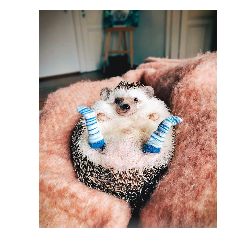

I have no idea what that is!

SUMMARY
-------
Dog detected: False | Face detected: False | Breed classification: N\A




In [88]:
app.interpret_image("other1.jpg", use_cnn_face_detector=False)

I'm looking at dog1.jpg:


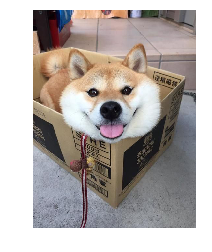

I think this is a dog, that looks like a...


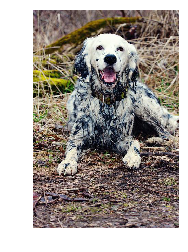

English Setter!

SUMMARY
-------
Dog detected: True | Face detected: False | Breed classification: English Setter




In [93]:
app.interpret_image("dog1.jpg", use_cnn_face_detector=False)

I'm looking at man1.jpg:


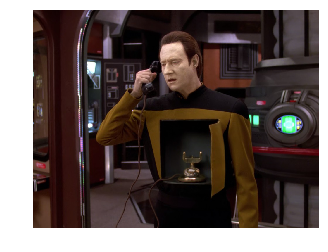

I think this is a person, that looks like a...


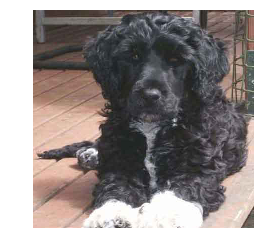

Black And Tan Coonhound!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Black And Tan Coonhound




In [104]:
app.interpret_image("man1.jpg", use_cnn_face_detector=False)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
Dog breed classification works poorly. Even though the model reached around 80% accuracy for the test set, the results provided in the app are not satisfactory. Even for dog images it fails to find the correct breed. A better model should be used.
Possible improvements:
1. Better training data augmentation.
2. Different architecture used as a base for transfer learning, such as GoogLeNet.
3. Longer training with different learning rates.
4. Using the cascade face detector greatly decreases the amount of false positives for face detection. Notice that in the second set of exaples below, where use_cnn_face_detector=True is used, the app detects a human face in each image. Even the one showing some eggplants ;)

I'm looking at dog1.jpg:


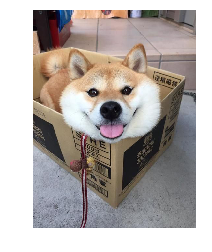

I think this is a dog, that looks like a...


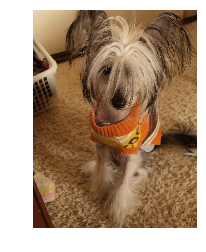

Chinese Crested!

SUMMARY
-------
Dog detected: True | Face detected: False | Breed classification: Chinese Crested


I'm looking at dog2.jpg:


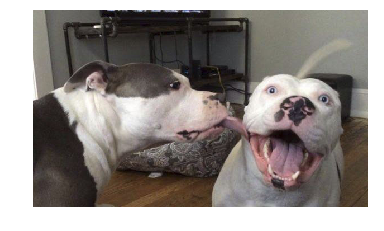

I think this is a dog, that looks like a...


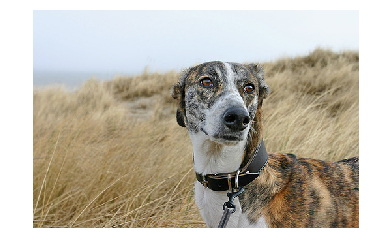

Greyhound!

SUMMARY
-------
Dog detected: True | Face detected: False | Breed classification: Greyhound


I'm looking at man1.jpg:


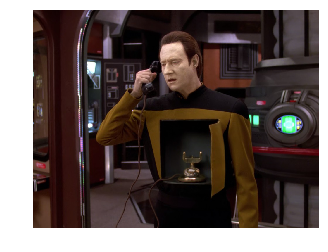

I think this is a person, that looks like a...


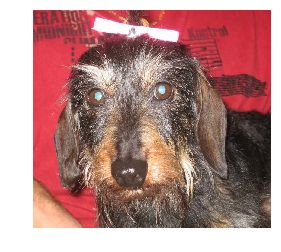

Dachshund!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Dachshund


I'm looking at man2.jpg:


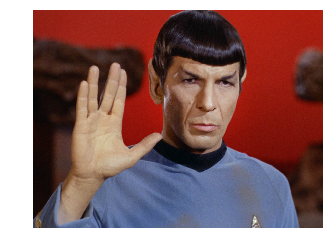

I think this is a person, that looks like a...


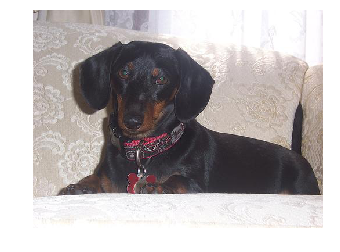

Dachshund!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Dachshund


I'm looking at other1.jpg:


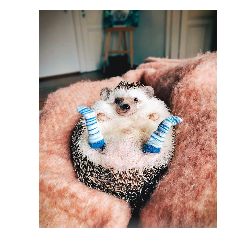

I have no idea what that is!

SUMMARY
-------
Dog detected: False | Face detected: False | Breed classification: N\A


I'm looking at other2.jpg:


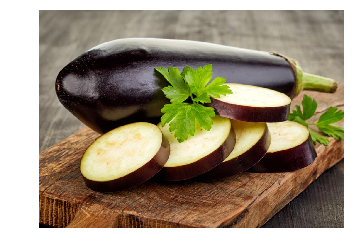

I have no idea what that is!

SUMMARY
-------
Dog detected: False | Face detected: False | Breed classification: N\A




In [96]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

images = ["dog1.jpg", "dog2.jpg", "man1.jpg", "man2.jpg", "other1.jpg", "other2.jpg"]
for image in images:
    app.interpret_image(image, use_cnn_face_detector=False)

I'm looking at dog1.jpg:


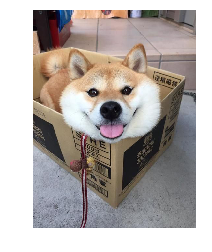

This could be both a dog or a person, but there's a striking resemblance to a...


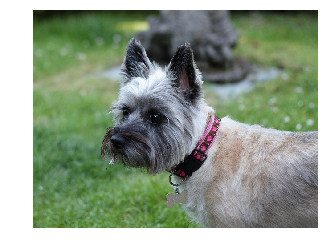

Cairn Terrier!

SUMMARY
-------
Dog detected: True | Face detected: True | Breed classification: Cairn Terrier


I'm looking at dog2.jpg:


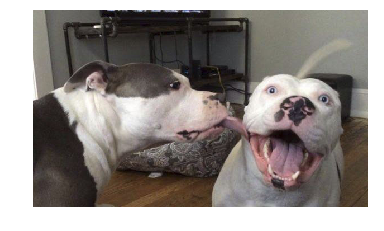

This could be both a dog or a person, but there's a striking resemblance to a...


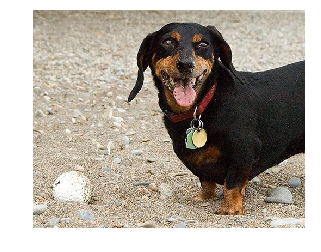

Dachshund!

SUMMARY
-------
Dog detected: True | Face detected: True | Breed classification: Dachshund


I'm looking at man1.jpg:


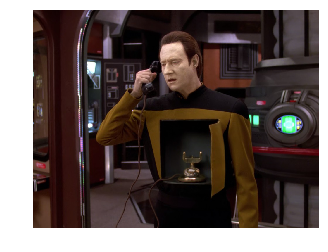

I think this is a person, that looks like a...


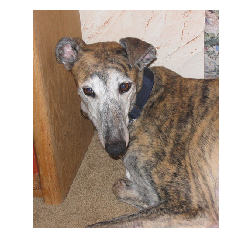

Greyhound!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Greyhound


I'm looking at man2.jpg:


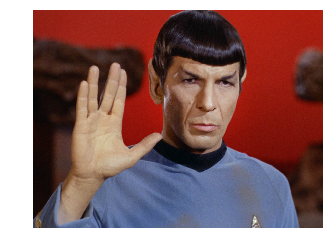

I think this is a person, that looks like a...


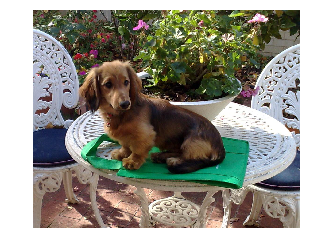

Dachshund!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Dachshund


I'm looking at other1.jpg:


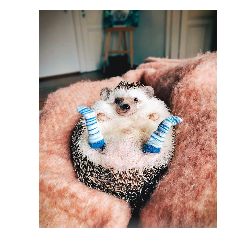

I think this is a person, that looks like a...


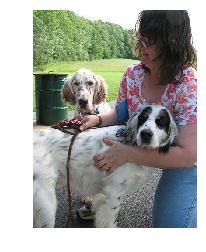

English Setter!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: English Setter


I'm looking at other2.jpg:


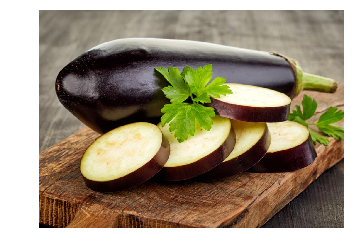

I think this is a person, that looks like a...


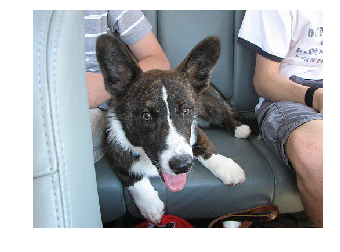

Cardigan Welsh Corgi!

SUMMARY
-------
Dog detected: False | Face detected: True | Breed classification: Cardigan Welsh Corgi




In [97]:
for image in images:
    app.interpret_image(image, use_cnn_face_detector=True)